In [1]:
import chess
import chess.pgn
import chess.engine
import csv
import os.path
import io
import re
import subprocess
import platform
import timeit
import random
import datetime
from contextlib import contextmanager

import pandas as pd
from tqdm import tqdm
from textwrap import wrap
from typing import List, Tuple, Generator, Union, Optional, Literal
import pyperclip as pc  # TODO remove

In [2]:
# Machine Learning
import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import wandb

WANDB_ENTITY = 'cs254-final-project'
WANDB_PROJECT_NAME = 'proj'

# Python chess basics
https://python-chess.readthedocs.io/en/latest/

# Sample PGN Data

In [ ]:
jackson_pgn = '''
[Event "Rated Bullet game"]
[Site "https://lichess.org/69CbaD8f"]
[Date "2021.10.07"]
[White "Cubigami"]
[Black "JoinedToday"]
[Result "1-0"]
[UTCDate "2021.10.07"]
[UTCTime "05:16:00"]
[WhiteElo "1930"]
[BlackElo "1912"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "60+0"]
[ECO "B01"]
[Opening "Scandinavian Defense: Mieses-Kotroc Variation"]
[Termination "Normal"]
[Annotator "lichess.org"]

1. e4 { [%eval 0.24] [%clk 0:01:00] } 1... d5?! { (0.24 → 0.82) Inaccuracy. e5 was best. } { [%eval 0.82] [%clk 0:01:00] } (1... e5 2. Nf3 Nc6 3. Bb5 Nf6 4. O-O Nxe4 5. Re1 Nd6 6. Nxe5) 2. exd5 { [%eval 0.36] [%clk 0:01:00] } 2... Qxd5 { [%eval 0.66] [%clk 0:01:00] } { B01 Scandinavian Defense: Mieses-Kotroc Variation } 3. Nc3 { [%eval 0.46] [%clk 0:01:00] } 3... Qe6+?! { (0.46 → 1.12) Inaccuracy. Qa5 was best. } { [%eval 1.12] [%clk 0:01:00] } (3... Qa5 4. Nf3 Nf6 5. d4 Bf5 6. Ne5 c6 7. Bf4 Nbd7 8. Nc4) 4. Be2 { [%eval 0.94] [%clk 0:00:59] } 4... Qg6? { (0.94 → 2.18) Mistake. Nf6 was best. } { [%eval 2.18] [%clk 0:01:00] } (4... Nf6 5. d4 Qd6 6. Nf3 e6 7. O-O Be7 8. Nb5 Qd8 9. c4) 5. Nf3 { [%eval 1.51] [%clk 0:00:58] } 5... Nc6?? { (1.51 → 4.52) Blunder. Qxg2 was best. } { [%eval 4.52] [%clk 0:00:59] } (5... Qxg2 6. Rg1 Qh3 7. d4 Nf6 8. Rg3 Qf5 9. Ne5 c6 10. Rf3) 6. O-O?? { (4.52 → 0.37) Blunder. Nb5 was best. } { [%eval 0.37] [%clk 0:00:57] } (6. Nb5 Kd8 7. d4 a6 8. d5 axb5 9. dxc6+ Ke8 10. Ne5 Qe6) 6... h5?? { (0.37 → 5.60) Blunder. Bh3 was best. } { [%eval 5.6] [%clk 0:00:59] } (6... Bh3 7. Ne1 Bf5 8. Nd5 O-O-O 9. Ne3 Nf6 10. Nf3 Be4 11. d3) 7. h4?? { (5.60 → 0.08) Blunder. Nb5 was best. } { [%eval 0.08] [%clk 0:00:56] } (7. Nb5 Bh3) 7... a6?? { (0.08 → 2.63) Blunder. Bh3 was best. } { [%eval 2.63] [%clk 0:00:58] } (7... Bh3 8. Ng5 Bf5 9. Bb5 f6 10. Nf3 e6 11. Nd4 Ne7 12. Qf3 Kd7 13. Re1 a6 14. Ba4) 8. Bd3?? { (2.63 → -0.22) Blunder. d4 was best. } { [%eval -0.22] [%clk 0:00:53] } (8. d4) 8... Qf6?? { (-0.22 → 1.46) Blunder. Bf5 was best. } { [%eval 1.46] [%clk 0:00:56] } (8... Bf5) 9. Ne4 { [%eval 1.24] [%clk 0:00:51] } 9... Qe6?! { (1.24 → 2.16) Inaccuracy. Qg6 was best. } { [%eval 2.16] [%clk 0:00:54] } (9... Qg6 10. Ng3) 10. Nfg5? { (2.16 → 0.77) Mistake. Neg5 was best. } { [%eval 0.77] [%clk 0:00:51] } (10. Neg5 Qd6 11. Bc4 Nh6 12. c3 Bf5 13. Qb3 O-O-O 14. Bxf7 e5 15. Be6+ Bxe6 16. Qxe6+ Qxe6) 10... Qd7?? { (0.77 → 8.62) Blunder. Qd5 was best. } { [%eval 8.62] [%clk 0:00:52] } (10... Qd5 11. Nc3 Qd8 12. Bc4 e6 13. Re1 Be7 14. d3 Nh6 15. Qxh5 g6 16. Qd1 Nf5 17. g3) 11. Qf3?? { (8.62 → -0.59) Blunder. Nxf7 was best. } { [%eval -0.59] [%clk 0:00:50] } (11. Nxf7) 11... f6?? { (-0.59 → 8.00) Blunder. Ne5 was best. } { [%eval 8.0] [%clk 0:00:50] } (11... Ne5 12. Qf4 f6 13. Be2 Nc6 14. Nf3 e5 15. Qe3 Nge7 16. Qb3 Qd5 17. d3 Qxb3 18. axb3) 12. Nc5 { [%eval 7.68] [%clk 0:00:47] } 12... Qd8? { (7.68 → Mate in 1) Checkmate is now unavoidable. Ne5 was best. } { [%eval #1] [%clk 0:00:49] } (12... Ne5 13. Bg6+ Nxg6 14. Nxd7 Bxd7 15. Qxb7 Rd8 16. Qe4 Nxh4 17. Ne6 Bxe6 18. Qxe6 Rd6 19. Qc4) 13. Nge6? { (Mate in 1 → 8.51) Lost forced checkmate sequence. Bg6# was best. } { [%eval 8.51] [%clk 0:00:45] } (13. Bg6#) 13... Bxe6 { [%eval 8.53] [%clk 0:00:43] } 14. Nxe6 { [%eval 8.78] [%clk 0:00:45] } 14... Qd7? { (8.78 → Mate in 1) Checkmate is now unavoidable. Ne5 was best. } { [%eval #1] [%clk 0:00:43] } (14... Ne5 15. Qxb7) 15. Bg6# { [%clk 0:00:45] } { White wins by checkmate. } 1-0'''

carlson_pgn = '''
[Event "Rated Blitz game"]
[Site "https://lichess.org/RzGPtofJ"]
[Date "2021.08.19"]
[White "Feokl1995"]
[Black "DrNykterstein"]
[Result "1/2-1/2"]
[UTCDate "2021.08.19"]
[UTCTime "22:35:41"]
[WhiteElo "2998"]
[BlackElo "3141"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[WhiteTitle "GM"]
[BlackTitle "GM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Opening "Nimzowitsch Defense: Williams Variation"]
[Termination "Normal"]
[Annotator "lichess.org"]

1. e4 { [%eval 0.24] [%clk 0:03:00] } 1... Nc6 { [%eval 0.44] [%clk 0:03:00] } 2. Nf3 { [%eval 0.24] [%clk 0:02:58] } 2... d6 { [%eval 0.71] [%clk 0:02:59] } { B00 Nimzowitsch Defense: Williams Variation } 3. d4 { [%eval 0.72] [%clk 0:02:57] } 3... Nf6 { [%eval 0.89] [%clk 0:02:58] } 4. Nc3 { [%eval 0.54] [%clk 0:02:56] } 4... g6 { [%eval 0.96] [%clk 0:02:58] } 5. h3?! { (0.96 → 0.42) Inaccuracy. Be3 was best. } { [%eval 0.42] [%clk 0:02:55] } (5. Be3 Bg7 6. Qd2 O-O 7. d5 Nb8 8. Bh6 c6 9. h3 b5) 5... Bg7 { [%eval 0.67] [%clk 0:02:57] } 6. Be2 { [%eval 0.5] [%clk 0:02:55] } 6... O-O { [%eval 0.5] [%clk 0:02:57] } 7. O-O { [%eval 0.34] [%clk 0:02:54] } 7... a6 { [%eval 0.4] [%clk 0:02:55] } 8. a4 { [%eval 0.53] [%clk 0:02:53] } 8... b6 { [%eval 0.62] [%clk 0:02:50] } 9. Be3 { [%eval 0.39] [%clk 0:02:52] } 9... e6 { [%eval 0.6] [%clk 0:02:47] } 10. e5 { [%eval 0.84] [%clk 0:02:41] } 10... dxe5 { [%eval 0.56] [%clk 0:02:46] } 11. Nxe5 { [%eval 0.57] [%clk 0:02:40] } 11... Bb7 { [%eval 0.73] [%clk 0:02:43] } 12. Bf3 { [%eval 0.81] [%clk 0:02:38] } 12... Nd5 { [%eval 0.91] [%clk 0:02:42] } 13. Nxd5 { [%eval 0.85] [%clk 0:02:36] } 13... exd5 { [%eval 0.75] [%clk 0:02:42] } 14. Nxc6 { [%eval 0.81] [%clk 0:02:31] } 14... Bxc6 { [%eval 0.87] [%clk 0:02:42] } 15. c3 { [%eval 0.75] [%clk 0:02:30] } 15... a5 { [%eval 1.03] [%clk 0:02:41] } 16. Bf4 { [%eval 0.6] [%clk 0:02:29] } 16... Qd7 { [%eval 0.88] [%clk 0:02:40] } 17. Re1 { [%eval 0.75] [%clk 0:02:28] } 17... Rfe8 { [%eval 0.79] [%clk 0:02:39] } 18. b3 { [%eval 0.36] [%clk 0:02:26] } 18... Rxe1+ { [%eval 0.35] [%clk 0:02:37] } 19. Qxe1 { [%eval 0.45] [%clk 0:02:26] } 19... Re8 { [%eval 0.42] [%clk 0:02:36] } 20. Qd2 { [%eval 0.55] [%clk 0:02:26] } 20... Bf8 { [%eval 0.36] [%clk 0:02:36] } 21. Re1 { [%eval 0.28] [%clk 0:02:19] } 21... Rxe1+ { [%eval 0.29] [%clk 0:02:35] } 22. Qxe1 { [%eval 0.45] [%clk 0:02:19] } 22... Bd6 { [%eval 0.25] [%clk 0:02:34] } 23. Qe3 { [%eval 0.22] [%clk 0:02:17] } 23... f6 { [%eval 0.42] [%clk 0:02:12] } 24. Bg4 { [%eval 0.14] [%clk 0:02:12] } 24... Qd8 { [%eval 0.63] [%clk 0:02:09] } 25. Qe6+ { [%eval 0.44] [%clk 0:02:10] } 25... Kg7 { [%eval 0.47] [%clk 0:02:07] } 26. Bxd6 { [%eval 0.4] [%clk 0:02:08] } 26... Qxd6 { [%eval 0.43] [%clk 0:02:07] } 27. Qxd6 { [%eval 0.42] [%clk 0:02:06] } 27... cxd6 { [%eval 0.43] [%clk 0:02:07] } 28. Bf3 { [%eval 0.45] [%clk 0:02:02] } 28... f5 { [%eval 0.43] [%clk 0:02:06] } 29. h4 { [%eval 0.21] [%clk 0:01:55] } 29... Kf6 { [%eval 0.21] [%clk 0:02:04] } 30. g3 { [%eval 0.26] [%clk 0:01:54] } 30... h6 { [%eval 0.36] [%clk 0:02:03] } 31. Be2 { [%eval 0.14] [%clk 0:01:51] } 31... Bd7 { [%eval 0.3] [%clk 0:01:59] } 32. f4 { [%eval 0.35] [%clk 0:01:50] } 32... h5 { [%eval 0.36] [%clk 0:01:58] } 33. Kf2 { [%eval 0.35] [%clk 0:01:50] } 33... Be6 { [%eval 0.34] [%clk 0:01:57] } 34. Ke3 { [%eval 0.34] [%clk 0:01:48] } 34... Ke7 { [%eval 0.29] [%clk 0:01:57] } 35. Kd2 { [%eval 0.21] [%clk 0:01:48] } 35... Kd8 { [%eval 0.34] [%clk 0:01:57] } 36. Bb5 { [%eval 0.32] [%clk 0:01:46] } 36... Bf7 { [%eval 0.19] [%clk 0:01:55] } 37. Kd3 { [%eval 0.19] [%clk 0:01:44] } 37... Kc7 { [%eval 0.26] [%clk 0:01:55] } 38. Ke3 { [%eval 0.39] [%clk 0:01:39] } 38... Kd8 { [%eval 0.35] [%clk 0:01:54] } 39. Kd2 { [%eval 0.52] [%clk 0:01:39] } 39... Kc7 { [%eval 0.36] [%clk 0:01:53] } 40. Kc2 { [%eval 0.23] [%clk 0:01:38] } 40... Kd8 { [%eval 0.3] [%clk 0:01:53] } 41. Kb2 { [%eval 0.25] [%clk 0:01:37] } 41... Kc7 { [%eval 0.27] [%clk 0:01:53] } 42. Kc2 { [%eval 0.34] [%clk 0:01:37] } 42... Kd8 { [%eval 0.17] [%clk 0:01:52] } 43. Kd2 { [%eval 0.33] [%clk 0:01:36] } 43... Kc7 { [%eval 0.17] [%clk 0:01:52] } { The game is a draw. } 1/2-1/2
'''

# Export Only the Valid Games in New PGN
Filter the games from Lichess's .pgn downloads to a new .pgn that only include games that are analyzed and have the tags in the game header that will be necessary for feature generation.

Only ~20% of the original Sep. 2015 PGN download are valid games. Exporting only these games to a new file will save time generating data later for learning.

In [4]:
''' Helper Functions'''

DEFAULT_ERROR_MSG = 'Please enter "y" or "n".'
def validate_yn(prompt: str, error_msg: str = DEFAULT_ERROR_MSG) -> bool:
    """ Get a yes/no answer. """
    response = input(prompt)
    while response.lower() not in ('y', 'yes', 'ya', 'n', 'no', 'nah'):
        print(error_msg)
        response = input(prompt)
    return response.lower() in ('y', 'yes')

def is_valid_analyzed_game(game: chess.pgn.Game) -> bool:
    """ Return True if certain conditions about the Game are met. """
    # Must have these tags to use as features later
    REQUIRED_TAGS = ('WhiteElo', 'BlackElo', 'TimeControl')
    if not all((tag in game.headers for tag in REQUIRED_TAGS)):
        return False

    # Filter correspondence games (time controls like 3 days/move)
    if game.headers['TimeControl'] == '-':
        return False

    # Make sure game has at least 2 moves in mainline
    for ply, node in enumerate(game.mainline()):
        # Don't return unanalyzed games
        if ply == 0:
            if '%eval' not in node.comment:
                return False
        else:
            # Reached the second ply, skip "else"
            break
    else:
        return False

    return True

''' Main Cleaning Function '''

FILTER_GAMES_WRITE_BATCH_SIZE = 10_000
def export_valid_games(pgn_filename: str,
                       output_pgn_filename: str = None,
                       max_games: Optional[int] = 1_000_000) -> Optional[str]:
    """
    Export a new file containing PGN strings for only the games in pgn_filename
    that are analyzed and have necessary info in the headers. The name of the new file
    will be the same as pgn_filename but with "___cleaned" appended. This should be run
    rarely to generate a new PGN file of the games we will be able to work with (and
    will print a warning if the output filename already exists).

    :param pgn_filename: The input filename
    :param output_pgn_filename: If set, the new PGN filename. Set to None to autogenerate
    :param max_games: Maximum number of games to write to the new file
    :return: The name of the newly-generated file
    """

    # PGN input file is required
    assert os.path.splitext(pgn_filename)[1].lower() == '.pgn'

    # Set filename if it wasn't given
    if output_pgn_filename is None:
        # Set the new name to be the input filename with ___cleaned
        name, extension = os.path.splitext(pgn_filename)
        output_pgn_filename = name + '___cleaned' + extension
    else:
        assert os.path.splitext(output_pgn_filename)[1].lower() == '.pgn'

    # Warn if overwriting
    if os.path.exists(output_pgn_filename):
        if not validate_yn(f'warning: {output_pgn_filename} will be overwritten even though its size is '
                           f'{os.path.getsize(output_pgn_filename) / 1e6:.2f}Mb. Continue? (y/n)'):
            print('Aborting.')
            return output_pgn_filename

    # Extract the valid games
    print(f'{datetime.datetime.now()}: Extracting valid games...')
    start_time = timeit.default_timer()
    with open(pgn_filename, 'r') as file:
        num_games_checked = 0
        total_num_valid_games_found = 0
        num_valid_games_stored = 0
        valid_games: List[str] = []

        output_file_started = False

        break_outer = False
        while not break_outer:
            # Get game
            game = chess.pgn.read_game(file)
            if game is None:
                # No more games left, write whatever remains and break
                print(f'{datetime.datetime.now()}: Writing {num_valid_games_stored} PGNs (total {total_num_valid_games_found})...', end='')
                with open(output_pgn_filename, ('w', 'a')[output_file_started]) as f:
                    f.write('\n\n\n'.join(valid_games) + '\n')
                print('done.')
                break

            # Skip invalid games
            is_valid = is_valid_analyzed_game(game)
            num_games_checked += 1
            if not is_valid:
                continue

            # Add to list
            valid_games.append(str(game))
            total_num_valid_games_found += 1
            num_valid_games_stored += 1

            # Wrap in try/else in case of PermissionError
            break_inner = False
            while not break_inner:
                try:
                    # Export list if current length > threshold (the elif)
                    # or if we have enough now to write max_games PGNs (the if)
                    if max_games is not None and total_num_valid_games_found == max_games \
                            or num_valid_games_stored >= FILTER_GAMES_WRITE_BATCH_SIZE:
                        # Write all PGNs and break
                        print(f'{datetime.datetime.now()}: Writing {num_valid_games_stored} PGNs (total {total_num_valid_games_found})...', end='')
                        with open(output_pgn_filename, ('w', 'a')[output_file_started]) as f:
                            f.write(''.join(pgn + '\n\n\n' for pgn in valid_games))
                        print('done.')
                        break_outer = True
                    elif num_valid_games_stored >= FILTER_GAMES_WRITE_BATCH_SIZE:
                        # Write all PGNs
                        print(f'{datetime.datetime.now()}: Writing {num_valid_games_stored} PGNs (total {total_num_valid_games_found})...', end='')
                        with open(output_pgn_filename, ('w', 'a')[output_file_started]) as f:
                            f.write(''.join(pgn + '\n\n\n' for pgn in valid_games))
                        print('done.')

                        # Reset valid games list to free up memory
                        valid_games = []
                        num_valid_games_stored = 0
                        output_file_started = True
                    break_inner = True
                except PermissionError:
                    input(f'warning: PermissionError while saving. Please close {output_pgn_filename} and press enter.')

    print()
    print('Results:')
    print(f'\t{total_num_valid_games_found:,} valid PGNs written to "{output_pgn_filename}" '
          f'({os.path.getsize(output_pgn_filename) / 1e6:.2f}Mb)')
    print(f'\t{num_games_checked:,} games checked for validity '
          f'({total_num_valid_games_found/num_games_checked:.2%} valid)')
    print(f'\t{timeit.default_timer() - start_time:.2f}s elapsed')

    return output_pgn_filename

The next cell will take a few hours to finish if `max_games=None`. It should have time if left running overnight.

In [ ]:
RAW_PGN_FILENAME = 'data/lichess_db_standard_rated_2015-09.pgn'
CLEANED_PGN_FILENAME = export_valid_games(RAW_PGN_FILENAME, max_games=None)

# Helper Functions for Feature Extraction

In [5]:
def generate_games(pgn_filename: str,
                   max_games: int = 1_000_000,
                   validate: bool = False) -> Generator[str, None, None]:
    """
    Take a PGN filename and return a generator that loops over the first num_games games. If
    validate is True, check whether a game is valid before yielding it (set to False if using
    a "...___cleaned.pgn" input file).
    """
    with open(pgn_filename, 'r') as file:
        num_games_yielded = 0
        while True:
            if num_games_yielded > max_games:
                return

            game = chess.pgn.read_game(file)

            # No more games in the PGN
            if game is None:
                return

            # No need to check for validity here if using ...___cleaned.pgn file
            if validate:
                if not is_valid_analyzed_game(game):
                    continue

            yield game
            num_games_yielded += 1

EVAL_REGEX_PAT = '\[%eval ([+-]?(?:[0-9]*[.])?[0-9]+|#-?[0-9]+)]'
def get_score_from_comment(comment: str) -> float:
    """ Return the pawn-score in the comment if it contains "%eval". If "%eval" not in comment, raises ValueError. """
    if '%eval' not in comment:
        raise ValueError

    # Get score part using regex
    evals = re.findall(EVAL_REGEX_PAT, comment)
    assert len(evals) == 1, f'error: "%eval" tag does not appear exactly once in move.comment = {comment}'
    score = evals[0]

    # Convert to float
    try:
        score = float(score)
    except ValueError:
        # Only explanation for ValueError should be that %eval's score is a checkmate, ex. '#-5' or '#9'
        # Convert to centipawn-score with mate_score, then /100 to get pawn-score
        # https://python-chess.readthedocs.io/en/latest/engine.html?highlight=mate_score#chess.engine.Score.score
        assert '#' in score
        score = chess.engine.Mate(int(score.lstrip('#'))).score(mate_score=10_000) / 100.0
    return score

CLK_REGEX_PAT = '\[%clk (.*?)]'
def get_time_remaining_from_comment(comment: str) -> int:
    """
    Return the time remaining in seconds given by the "%clk" tag in the comment (always appears as an int).
    If "%clk" not in comment, raise ValueError.
    """
    if '%clk' not in comment:
        raise ValueError

    # Get eval part using regex
    clk = re.findall(CLK_REGEX_PAT, comment)
    assert len(clk) == 1, f'error: "%clk" tag does not appear exactly once in move.comment = {comment}'
    clk = clk[0]

    parts = clk.split(':')
    assert len(parts) == 3
    seconds_remaining = int(parts[0]) * 3600 \
                     + int(parts[1]) * 60 \
                     + int(parts[2])
    return seconds_remaining

def get_cpl(from_score: float, to_score: float, after_move_by: chess.Color) -> int:
    """ Get centipawn loss (CPL) based on scores of consecutive moves and the side to move. """
    return round((from_score - to_score) * 100) * (1 if after_move_by == chess.WHITE else -1)

def parse_time_control(time_control: str) -> Tuple[int, int]:
    """ Convert a time control string like "300+3" . """
    if time_control == '-':
        # Correspondence game (ex. 3 days per move)
        # Assume the longest time control of 120+120
        return 7200, 120

    x = time_control.split('+')
    return int(x[0]), int(x[1])

# Engine Functions

In [6]:
@contextmanager
def start_engine_process() -> Generator[subprocess.Popen, None, None]:
    # Set Stockfish file according to OS
    system = platform.system()
    if system == 'Darwin':
        stockfish = './stockfish'
    elif system == 'Windows':
        stockfish = 'stockfish_14_x64_avx2.exe'
    else:
        raise OSError(f'error: Unsupported operating system {system}')

    # Open the exe using Popen
    p = subprocess.Popen(stockfish,
                         stdin=subprocess.PIPE,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE)

    # Send commands to this open process by using stdin.write(*command*)
    send_commands(p, 'isready\n')

    # Allows for "with start_engine_process() as p: ..."
    try:
        yield p
    finally:
        p.terminate()

def send_commands(p: subprocess.Popen, *commands: str) -> None:
    if not commands:
        return

    for cmd in commands:
        p.stdin.write(cmd.encode())

    p.stdin.flush()

def analyze_static(p: subprocess.Popen, fen: str) -> str:
    """ Return the full string output of Stockfish's static evaluation for the given FEN. """

    send_commands(p, f'position fen {fen}\n', 'eval\n')

    # Get as many str lines as were output
    lines = []
    while True:
        line = p.stdout.readline().decode().strip()
        lines.append(line.strip('\n\r'))

        # Static eval does not run on positions where either king is in check
        if 'none (in check)' in line or 'Final evaluation' in line:
            break

    return '\n'.join(lines)

##### Testing

In [ ]:
with start_engine_process() as p:
    # In-check position shouldn't give static eval
    print(analyze_static(p, 'r3r3/pppkb1pp/8/n2nN3/8/8/PPPP1PPP/RNB1K2R b KQ - 2 12'))

    print('========================')

    # Other positions should give static eval
    output = analyze_static(p, 'r1bk1bnr/1pp2ppp/p1n2q2/3N2N1/6B1/8/PPP2PPP/R1BQK2R b KQ - 0 12')
    print(output)

# Feature Generation from Game Data

In [7]:
def vectorize_contributing_terms(static_analysis_output: str) -> np.ndarray:
    """
    Return an array with shape (68,) of numbers from the "Contributing terms..." table
    given by the Stockfish static analysis.
    """
    # Regex tester
    # https://regex101.com/r/OWV1ee/4
    return np.array([float(i)
                     for tup in re.findall('([-]?(?:[0-9]*[.])?[0-9]+) +([-]?(?:[0-9]*[.])?[0-9]+)', static_analysis_output)
                     for i in tup])

_BOARD = chess.Board()
def vectorize_board_state(*,
                          board: chess.Board = None,
                          fen: str = None,
                          packbits: bool = False) -> np.ndarray:
    """
    Take either a Board or a FEN and return a 3d vector of the board state with shape (8, 8, 12)
    if packbits is False, else (8, 8, 2). Each vector or int in the (8, 8) outer vectors returned
    is a one-hot encoding of the piece type at that square.

    Method taken from here: https://chess.stackexchange.com/a/34399/19286

    One-hot encoding examples:
        format: pnbrqkPNBRQK
                ------------
                000010000000 = black queen
                000000010000 = white knight

    :param board: Board object (preferred if available)
    :param fen: String to make a new Board object
    :param packbits: If True, each square's one-hot encoding is packed into the
            binary representation of two np.bytes, instead of a vector of 0/1 ints.
            See https://numpy.org/doc/stable/reference/generated/numpy.packbits.html
    """

    # Provide Board or FEN, not both
    assert (board, fen).count(None) == 1, f'error: vectorize_board_state() takes either a Board or a FEN str, not both'
    if board is None:
        _BOARD.set_fen(fen)
        board = _BOARD

    # Bitboards of all white and black pieces
    black, white = board.occupied_co

    # Bitboards each piece type by color
    bbs = np.array([
        black & board.pawns,
        black & board.knights,
        black & board.bishops,
        black & board.rooks,
        black & board.queens,
        black & board.kings,
        white & board.pawns,
        white & board.knights,
        white & board.bishops,
        white & board.rooks,
        white & board.queens,
        white & board.kings,
    ])

    result = np.array([np.array([np.array([int(ch) for ch in row]).astype(np.int16, copy=False)
                             for row in wrap(f'{str(bin(int(bb)))[2:]:0>64}', 8)])
                   for bb in bbs]).swapaxes(0, 1).swapaxes(1, 2)
    assert result.shape == (8, 8, 12)

    if packbits:
        result = np.packbits(result, axis=-1)
        assert result.shape == (8, 8, 2)

    return result

def unpack_vectorized_board_state(packed_vectorized_board_state: np.ndarray) -> np.ndarray:
    """
    Takes a vectorized board state array with packed bits (the result of calling
    vectorize_board_state(..., packbits=True)) and unpack the bits back into a one-hot
    encoded vector (the result of vectorize_board_state(..., packbits=False))
    """
    assert packed_vectorized_board_state.shape == (8, 8, 2)
    return np.unpackbits(packed_vectorized_board_state, axis=-1)[:,:,:12].astype(np.int16)

# Stockfish's starting eval, the eval before any moves are made
START_POSITION_EVAL = +0.3
# Manually store number of features expected to be
# returned to make sure everything works properly
# CURRENT_NUM_FEATURES = 841
CURRENT_NUM_FEATURES = 74
def vectorize_game_moves(proc: subprocess.Popen,
                         game: chess.pgn.Game,
                         max_moves: int = None,
                         score_type: Literal['cp', 'cpl'] = 'cpl') -> np.ndarray:
    """
    Return a (max(#plies, max_moves if not None))x(CURRENT_NUM_FEATURES + 1) array. If max_moves is set,
    a random set of max_moves moves will be chosen from the game to process and return, however
    occasionally the number of rows in the returned array will be < max_moves if either side is
    in check during a ply that was randomly selected to be included in the output (static eval
    doesn't work for in-check positions).

    For each ply (half-move) in the game, the following features are extracted:
        Game-specific features:
        - Player ELO rating
        - Opponent ELO rating
        - Rating gap (Opponent ELO - Player ELO)
        - Clock starting time (seconds)
        - Clock increment (seconds)
        Move-specific features:
        - Ply (# half-moves into the game)
        - Static eval features:
            - 68 features: floats from the "Contributing terms ..." table
            - (TODO) 64 features: floats from the "NNUE-derived piece values" table
                - Not sure how to deal with squares without pieces, filling with 0s might not make sense
        - Board state:
            - 768 features: 64 squares * 12 bits for one-hot encoded piece types

    The final column is the target column holding the centipawn loss (CPL) of the player's move in the position.

    :param max_moves: If None, as many plies from `game` will be vectorized as possible. This is
            always < 200 for this dataset, as plies after 200 are not analyzed (ie. starting at
            full-move 101). If an int is given, choose a random subset of `max_moves` plies to
            vectorize. If one of these plies is a check, vectorization won't work, so skip it.
            Therefore the number of rows returned may be < `max_plies` for this reason, or if
            `game` has < `max_plies` plies.
    :param score_type: Either "cp" or "cpl": whether target column stores the position's CP score or
            the CP loss made by the player in the position
    """

    # Data to be returned
    # Storing as builtin list type is slightly faster than np.array
    data = []

    # Set up board and Game's move nodes
    board = game.board()
    mainline_nodes: List[chess.pgn.ChildNode] = list(game.mainline())
    if len(mainline_nodes) < 2:
        raise ValueError(f'error: fewer than two moves in the game\'s mainline. '
                         f'Is game from a ...___cleaned.pgn? game: {game}')

    # Get indices of plies to use. If max_moves given, use only a subset of all game moves
    plies_to_use = set(range(len(mainline_nodes)))
    if max_moves is not None:
        if not isinstance(max_moves, int) or max_moves <= 0:
            raise ValueError('error: max_moves should be an int > 0')
        if max_moves < len(plies_to_use):
            # Bulitin random.sample is faster than the np options
            plies_to_use = set(random.sample(plies_to_use, max_moves))
    if not plies_to_use:
        print(f'warning: plies_to_use is empty. Is game from a ...cleaned.pgn? game: {game}')

    ''' Add row to `data` for each move '''
    # Set game-specific features (constants while iterating over moves in the game)
    h = game.headers
    try:
        clock_start, clock_inc = parse_time_control(h['TimeControl'])
    except ValueError as e:
        print(f'error: ValueError parsing time control. Is game from a ...___cleaned.pgn? '
              f'game: {game}')
        raise e
    try:
        white_elo = int(h['WhiteElo'])
        black_elo = int(h['BlackElo'])
    except KeyError as e:
        # No player ratings in the game headers, should be using cleaned data
        print(f'error: KeyError for "WhiteElo" or "BlackElo" in game.headers. '
              f'Is game from a ...___cleaned.pgn? game.headers: {game.headers}')
        raise e
    game_features_white = np.array([h['WhiteElo'], h['BlackElo'], (black_elo-white_elo), clock_start, clock_inc])
    game_features_black = np.array([h['BlackElo'], h['WhiteElo'], (white_elo-black_elo), clock_start, clock_inc])

    # Add row of features for all selected moves in the Game
    last_score: float = START_POSITION_EVAL
    for ply, node in enumerate(mainline_nodes):
        # Break condition: last ply's node may not have "%eval"
        # in the comment (if its move gives checkmate/stalemate)
        try:
            score = get_score_from_comment(node.comment)
        except ValueError as e:
            # For this dataset, %eval comments stop at ply 200 (0-indexed, ex. white's move 101)
            if ply == 200:
                break

            # Can't get cpl if this move has no %eval
            # If there's no %eval because it's the last ply, that's fine
            if ply == len(mainline_nodes)-1:
                board.push(node.move)
                assert board.is_game_over(claim_draw=True)
                break

            # Otherwise something weird is going on
            print(f'error: ValueError getting score from comment: {e}')
            print(f'\tgame link: {game.headers["Site"]}')
            print(f'\tcomment: {node.comment}')
            print(f'\tply: {ply}')
            print(f'\ttotal # plies: {len(mainline_nodes)}')
            print(f'\tfen: {board.fen()}')
            print(f'\tmove: {board.san(node.move)}')
            raise e

        # Continue if in check (can't get static eval in check)
        # and skip move if this ply was not chosen to be used
        if board.is_check() or ply not in plies_to_use:
            last_score = score
            try:
                board.push(node.move)
                continue
            except AssertionError as e:
                # Something weird going on, python-chess thinks move is illegal
                print(f'warning: AssertionError while pushing move: {e}')
                print(f'\tmove: {node.move}')
                print(f'\tboard.fen(): {board.fen()}')
                print(f'\tply: {ply}')
                print(f'\tplies_to_use: {plies_to_use}')
                break

        # Get game-specific features
        game_features = (game_features_black, game_features_white)[board.turn == chess.WHITE]

        # Set move-specific features
        static_eval_features = vectorize_contributing_terms(analyze_static(proc, board.fen()))
        # board_state_features = vectorize_board_state(board, flatten=True)
        board_state_features = [board.fen()]

        if score_type == 'cpl':
            # Set centipawn loss (CPL)
            cpl = get_cpl(last_score, score, board.turn)

            # # CPL should rarely be < 0 (player makes a move better than top computer line)
            # if cpl < 0:
            #     print('test: cpl less than 0')
            #     print(f'\tmove made by {chess.COLOR_NAMES[board.turn]}')
            #     print(f'\tlast_score: {last_score}')
            #     print(f'\tscore: {score}')
            #     print(f'\tcpl: {cpl}')
            #     print(f'\tboard.fen(): {board.fen()}')
            #     print(f'\tmove: {board.san(node.move)}')

            # Create row
            all_features = np.array([*game_features, *static_eval_features, *board_state_features, cpl])
        else:
            # Get CP score, not CP loss
            cp = score*100

            # Create row
            all_features = np.array([*game_features, *static_eval_features, *board_state_features, cp])


        # # Validate shape
        assert all_features.shape == (CURRENT_NUM_FEATURES+1,), f'error: all_features wasn\'t properly formed. all_features: {all_features}'

        # Add the row
        data.append(all_features)

        # Play next move
        board.push(node.move)
        last_score = score

    return np.array(data)

##### Testing

In [ ]:
''' Board state vectorization '''
print(vectorize_board_state(board=chess.Board()))
print('\n\n================\n\n')
print(vectorize_board_state(board=chess.Board(), packbits=True))
# print('\n\n================\n\n')
# print(vectorize_board_state(fen=chess.STARTING_FEN))

# How to unpack bits from the result if packbits=True set
assert np.all(np.equal(
    unpack_vectorized_board_state(vectorize_board_state(board=chess.Board(), packbits=True)),
    vectorize_board_state(board=chess.Board(), packbits=False))
)

In [ ]:
''' Get game data for the two test PGNs '''
with start_engine_process() as p:
    NUM_MOVES = None

    carlson_game = chess.pgn.read_game(io.StringIO(carlson_pgn))
    jackson_game = chess.pgn.read_game(io.StringIO(jackson_pgn))

    carlson_game_data = vectorize_game_moves(p, carlson_game, max_moves=NUM_MOVES)
    jackson_game_data = vectorize_game_moves(p, jackson_game, max_moves=NUM_MOVES)

In [ ]:
# Data for Magnus Carlson's game
# Last column (CPL) should be around 0 (+/- 30) because both players played accurately
# Occasionally CPL can be <0 since both players are so high rated they found moves
# that the engine underestimated or didn't consider at a low depth
carlson_game_data

In [ ]:
# Data for Jackson's game
# Last column (CPL) should be higher, fluctuate more, and rarely/never be <0
jackson_game_data

# Make a CSV Dataset

Above are functions to export data points (training examples) for a single game. This reads from multiple games to generate a CSV that combines all their data.

In [8]:
def export_to_csv(csv_filename: str, data: np.array, reset_file: bool = False) -> None:
    """
    Export a given 2d numpy array to a csv file. If reset_file is True,
    open in write mode, else open in append mode.
    """
    open_mode = ('a', 'w')[reset_file]
    while True:
        try:
            with open(csv_filename, open_mode) as f:
                np.savetxt(f, data, fmt='%s', delimiter=',')
            break
        except PermissionError:
            input(f'error: PermissionError while writing file. Please close '
                  f'{csv_filename} and press enter: ')

PREPARE_DATA_WRITE_BATCH_SIZE = 900
def create_dataset(pgn_filename: str,
                   output_csv_filename: str = None,
                   max_datapoints: int = None,
                   max_datapoints_per_game: int = None,
                   score_type: Literal['cp', 'cpl'] = 'cpl') -> Optional[str]:
    """
    Process games using vectorize_game_moves() and export results to output_csv_filename in batches of
    PREPARE_DATA_WRITE_BATCH_SIZE.

    :param pgn_filename: Input filename. Should be a "...___cleaned.pgn" if one has been generated.
    :param output_csv_filename: CSV where data will be stored. If set to None, a descriptive filename
            will be generated.
    :param max_datapoints: If set, limits the number of points (rows) that will be included in the output file
    :param max_datapoints_per_game: If set, chooses a random subset of each game's moves to process. If None,
            all moves in each game will be processed until the file is exhausted or max_datapoints rows have
            been collected.
    :param score_type: Whether target column should be CP (engine score at a given position) or CPL (diff
            in CP between engine score and user's move)
    """

    # Input file must be PGN
    assert os.path.splitext(pgn_filename)[1].lower() == '.pgn'

    # Set filename if it wasn't given
    if output_csv_filename is None:
        # Set the new name to be the input filename with a descriptive name appended
        name, _ = os.path.splitext(pgn_filename)
        middle_part = '___data'
        if max_datapoints_per_game is not None:
            middle_part += f'_max_{max_datapoints_per_game}_moves_per_game'
        else:
            middle_part += '_no_max_moves_per_game'
        middle_part += f'_{score_type}'
        output_csv_filename = name + middle_part + '.csv'
    else:
        assert os.path.splitext(output_csv_filename)[1].lower() == '.csv'

    # Warn if overwriting
    if os.path.exists(output_csv_filename):
        if not validate_yn(f'warning: {output_csv_filename} will be overwritten even though its size is '
                           f'{os.path.getsize(output_csv_filename) / 1e6:.2f}Mb. Continue? (y/n)'):
            print('Aborting.')
            return output_csv_filename

    # Vectorize moves in games and write output file
    start_time = timeit.default_timer()
    empty_data = np.empty((0, CURRENT_NUM_FEATURES + 1))
    data = empty_data.copy()
    with start_engine_process() as proc:
        num_games = 0               # Incremented each game
        total_num_datapoints = 0    # Incremented each move
        num_datapoints = 0          # Incremented each move, reset when data is appended to csv
        num_discarded = 0
        output_file_started = False

        # tqdm just shows a progress bar
        # https://github.com/tqdm/tqdm
        for game in tqdm(generate_games(pgn_filename)):
            # Get new data
            new_data = vectorize_game_moves(proc, game, max_moves=max_datapoints_per_game, score_type=score_type)
            data = np.concatenate((data, new_data), axis=0)

            # Update counting vars
            num_games += 1
            num_datapoints += new_data.shape[0]
            total_num_datapoints += new_data.shape[0]

            # Append to CSV and reset `data` after it has more than PREPARE_DATA_WRITE_BATCH_SIZE rows (to save RAM)
            if max_datapoints is not None and total_num_datapoints >= max_datapoints:
                # Write only the number of rows that would give the file max_datapoints rows
                num_discarded = total_num_datapoints - max_datapoints
                data_to_write = data[:-num_discarded,:]

                print(f'{datetime.datetime.now()}: Writing final {data_to_write.shape[0]} rows '
                      f'(total {max_datapoints})...', end='')
                export_to_csv(csv_filename=output_csv_filename, data=data_to_write, reset_file=not output_file_started)
                print('done.')

                break
            elif num_datapoints >= PREPARE_DATA_WRITE_BATCH_SIZE:
                # Write all rows
                print(f'{datetime.datetime.now()}: Writing {num_datapoints} rows '
                      f'(total {total_num_datapoints})...', end='')
                export_to_csv(csv_filename=output_csv_filename, data=data, reset_file=not output_file_started)
                print('done.')

                # Reset data array to free up memory
                data = empty_data.copy()
                num_datapoints = 0
                output_file_started = True

    print('Results:')
    print(f'\t{min(total_num_datapoints, max_datapoints) if max_datapoints is not None else total_num_datapoints:,} '
          f'data points written to "{output_csv_filename}" '
          f'({os.path.getsize(output_csv_filename) / 1e6:.2f}Mb)')
    print(f'\t{total_num_datapoints:,} plies vectorized ({num_discarded} discarded)')
    print(f'\t{num_games:,} games parsed '
          f'(<={max_datapoints_per_game if max_datapoints_per_game is not None else 200} plies vectorized per game)')
    print(f'\t{timeit.default_timer() - start_time:.2f}s elapsed')

    return output_csv_filename

In [11]:
# This filename can also be set above if export_valid_games() is called
# noinspection PyRedeclaration
CLEANED_PGN_FILENAME = 'data/lichess_db_standard_rated_2015-09___cleaned.pgn'
data_filename = create_dataset(CLEANED_PGN_FILENAME,
                               max_datapoints=100_000,
                               max_datapoints_per_game=None,
                               score_type='cp')

Aborting.


# Load Random Sample of CSV Dataset

In [9]:
def load_moves_data(csv_filename: str,
                    sample_size: int = 10_000,
                    max_population: Optional[int] = 1_000_000,
                    include_numeric: bool = True,
                    include_fens: bool = True,
                    vectorize_fens: bool = False,
                    include_target: bool = True,
                    split_X_y: bool = False,
                    split_numeric_fens: bool = False,
                    target_class_threshold: float = None) \
        -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    """
    Load a random sample of all data from the given CSV into a numpy array. There are a lot of
    configurable options below to choose from that will suit a range of ML applications.

    :param csv_filename: Input file where data will be read from
    :param sample_size: Number of rows to be returned. If csv_filename doesn't have sample_size rows,
            a warning is printed and all rows are returned in order in the specified format.
    :param max_population: Maximum number of rows that will be read from the file to potentially be
            chosen in the random sample. Ex. if csv_filename has 10M rows but max_population is 100K,
            only the first 100K rows of the file will be iterated over.
    :param include_numeric: If True, include the numeric feature columns in the output (ex. game data,
            static eval features, etc.), otherwise remove them.
    :param include_fens: If True, include the FEN column in the output. In this case, if
            split_numeric_fens is also False, all feature columns (even numeric ones) will have type
            np.str_, not useful for machine learning. To avoid this, either set include_numeric=False
            or split_numeric_fens=True. Then only the FEN array will have type np.str_, and other types
            will be set to np.float32 automatically. If False, remove the FEN column and automatically
            set all other numeric dtypes to np.float32.
    :param vectorize_fens: If True, include_numeric must be False and split_X_y must be True so that
            the FEN column in the output is isolated in a single np.array. This is to preserve dtypes of
            the array that is output by vectorize_board_state(). If True, calls
            vectorize_board_state(packbits=False) for each FEN in the FEN column to produce an output
            array with shape (sample_size, 8, 8, 12). Otherwise, the FEN column are returned as strings
            (specifically as np.str_ types).
    :param include_target: If True, include the target column in the output, otherwise remove it.
    :param split_X_y: If True, return an array `X` with the features and a column vector `y` with the
            targets, otherwise return a single array with the included data
    :param split_numeric_fens: If True, split_X_y must be True. Return 3 arrays `X` with the numeric
            features, `fens` with the FENs, and `y` with the targets.
    :param target_class_threshold: If a float is provided, turns the target column into binary classes
            where all CPLs less than the threshold are 0 and all greater than the threshold are 1. If
            None, target columns will be the original CPL, an array of np.float32s.

    """

    ''' Validate inputs '''
    if max_population is not None:
        if sample_size > max_population:
            raise ValueError('error: sample_size should be <= max_population')

    if not any((include_numeric, include_fens, include_target)):
        raise ValueError('error: no columns selected to be returned (one of '
                         'include_numeric, include_fens, include_target must be True)')

    if split_numeric_fens and not all((include_numeric, include_fens)):
        raise ValueError('error: if split_numeric_fens=True, include_numeric and include_fens must be True')

    if (not any((include_numeric, include_fens)) or not include_target) and split_X_y:
        raise ValueError('error: if split_X_y=True, one of (include_numeric, include_fens) must be True '
                         'and include_target must be True')

    if split_numeric_fens and not split_X_y:
        raise ValueError('error: if split_numeric_fens=True, split_X_y must be True')

    if vectorize_fens and not split_numeric_fens:
        if include_numeric or not include_fens or not split_X_y:
            raise ValueError('error: if vectorize_fens=True, make sure the following arguments are set:\n'
                             '\t- include_fens=True\n'
                             '\t- include_numeric=False\n'
                             '\t- split_X_y=True\n'
                             'to preserve the np.array dtype output by vectorize_board_state(). Otherwise '
                             'all types will be cast to np.str_.')

    if target_class_threshold is not None and not include_target:
        raise ValueError('error: if target_class_threshold=True, include_target must be True')

    ''' Take a random sample of CSV rows as strings '''
    # This method is from Answer #3 here:
    # https://www.py4u.net/discuss/21578
    buffer = []
    with open(csv_filename, 'r') as f:
        for line_num, line in tqdm(enumerate(f)):
            if max_population is not None and line_num == max_population:
                break

            line_num += 1
            if line_num <= sample_size:
                # Add first sample_size elements
                buffer.append(line.strip())
            elif random.random() < sample_size/line_num:
                # Eject a random element from buffer
                idx = random.randint(0, sample_size-1)
                buffer[idx] = line.strip()
    print('Converting CSV rows to np.arrays...', end='')
    data = np.array(list(csv.reader(buffer)))
    numeric, fens, target = data[:,:-2].astype(np.float32), data[:,-2], data[:,-1].astype(np.float32)
    print('done.')

    if sample_size > data.shape[0]:
        print(f'warning: There were only {data.shape[0]:,} < sample_size={sample_size:,} rows '
              f'in {csv_filename}. All {data.shape[0]:,} rows were returned.')

    ''' Delete unwanted columns '''
    if not include_numeric:
        numeric = np.delete(numeric, slice(None), axis=-1)

    if not include_fens:
        # Safe to convert types now
        fens = np.delete(fens, slice(None), axis=-1)
    elif vectorize_fens:
        # Safe to vectorize now because error is raised above if include_numeric=True
        print('Vectorizing FENs...', end='')
        fens = np.array([vectorize_board_state(fen=fen) for fen in fens.ravel()])
        print('done.')
    elif include_numeric and not split_numeric_fens:
        print(f'warning: numeric dtypes ({"EX" if split_X_y else "IN"}CLUDING target) are still np.str_ '
              '(numpy doesn\'t do well with multi-type arrays). They will need to be converted to np.float32 manually '
              'unless load_moves_data() is called with include_fens=False, or with split_numeric_fens=True to place the '
              'FENs into a new column - in either case all numeric data will be converted to np.float32 dtypes '
              'automatically.')

    if not include_target:
        target = np.delete(target, slice(None), axis=-1)

    if target_class_threshold is not None:
        target = np.array([int(cpl < target_class_threshold) for cpl in target], dtype=np.float32)

    ''' Set & return appropriate result '''
    # A mess of logic but it works
    if split_X_y:
        if split_numeric_fens:
            result = numeric, fens, target
        else:
            if include_numeric and include_fens:
                result = np.concatenate((numeric, fens.reshape((-1, 1))), axis=-1), target
            elif include_numeric:
                result = numeric, target
            else:
                assert include_fens  # Only other path
                result = fens, target
    else:
        if include_numeric and include_fens and include_target:
            result = np.concatenate((numeric, fens.reshape((-1, 1)), target.reshape((-1, 1))), axis=-1)
        elif include_numeric and include_fens:
            result = np.concatenate((numeric, fens.reshape((-1, 1))), axis=-1)
        elif include_numeric and include_target:
            result = np.concatenate((numeric, target.reshape((-1, 1))), axis=-1)
        elif include_fens and include_target:
            result = np.concatenate((fens.reshape((-1, 1)), target.reshape((-1, 1))), axis=-1)
        elif include_numeric:
            result = numeric
        elif include_fens:
            result = fens
        else:
            assert include_target  # Only other path
            result = target

    return result

##### Testing

In [12]:
data = load_moves_data(
    csv_filename=data_filename,
    sample_size=100,
    max_population=1_000_000,
    include_numeric=True,
    include_fens=True,
    vectorize_fens=False,
    include_target=True,
    split_X_y=True,
    split_numeric_fens=True,
    target_class_threshold=None,
)
data[2]

100000it [00:00, 319327.10it/s]

Converting CSV rows to np.arrays...done.


array([ 3.820e+02, -9.993e+03,  1.140e+02, -1.710e+02, -4.000e+01,
        3.400e+01, -1.000e+01, -7.000e+01,  6.700e+01,  6.000e+00,
        1.250e+02,  3.900e+01, -1.871e+03,  2.144e+03, -1.220e+02,
       -3.890e+02, -4.210e+02,  1.930e+02,  3.120e+02,  1.400e+01,
       -1.200e+01, -1.398e+03,  1.500e+01, -1.660e+02, -2.000e+00,
        1.700e+01,  4.460e+02,  1.100e+01,  6.000e+01,  5.531e+03,
        0.000e+00,  3.000e+00, -5.600e+01, -3.400e+01,  3.700e+01,
        4.200e+01,  1.600e+01, -7.090e+02,  3.470e+02,  5.100e+01,
       -6.400e+02,  1.371e+03,  0.000e+00, -2.000e+01,  4.910e+02,
        2.700e+01,  1.000e+01,  0.000e+00, -2.000e+02,  2.400e+01,
        8.400e+01, -7.150e+02,  1.518e+03,  8.000e+00, -6.000e+00,
       -1.090e+02, -8.300e+01, -2.680e+02,  6.700e+01,  9.200e+01,
       -2.200e+01, -9.993e+03, -8.640e+02,  6.960e+02, -2.300e+01,
       -4.300e+01, -1.740e+02, -1.306e+03,  5.900e+01,  9.900e+01,
        3.340e+02,  4.600e+02,  6.300e+01, -8.990e+02,  1.065e

# Machine Learning

# Test 1: Random Forest Model (Regression)

Using only numeric features (numbers given by static eval, not the board state), try to predict CPL.

##### Prepare Data

In [15]:
''' Load data '''
X, y = load_moves_data(
    csv_filename='data/lichess_db_standard_rated_2015-09___cleaned___data_max_20_moves_per_game_cpl.csv',
    sample_size=50_000,
    max_population=300_000,
    include_numeric=True,
    include_fens=False,
    include_target=True,
    split_X_y=True,
    target_class_threshold=30)

''' Feature scaling '''
# Taken from https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
scaler = skl.preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# TODO not sure if target col should be scaled?
# scaler = skl.preprocessing.MinMaxScaler()
# y_scaled = scaler.fit_transform(y.reshape((-1, 1))).ravel()

''' Train/test/validate split '''
# X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X_scaled, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5)

''' Delete unneeded vars '''
del X, y, X_test_and_val, y_test_and_val, X_scaled#, y_scaled

300000it [00:00, 308515.26it/s]


Converting CSV rows to np.arrays...done.


In [16]:
# Check shapes
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'y_val.shape: {y_val.shape}')

X_train.shape: (40000, 73)
X_test.shape: (5000, 73)
X_val.shape: (5000, 73)
y_train.shape: (40000,)
y_test.shape: (5000,)
y_val.shape: (5000,)


In [ ]:
# Optional: show feature correlation

# Taken from https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
import seaborn as sb
correlation_matrix = pd.DataFrame(data=X_train).corr()
fig = plt.figure(figsize=(15,15))
sb.heatmap(correlation_matrix, vmax=0.8, square=True)
plt.show()

##### Fit Model

In [17]:
# Note: MAE criterion 10x slower than MSE
# reg = RandomForestRegressor(n_estimators=100, criterion='mse')
reg = RandomForestClassifier(n_estimators=100, criterion='entropy')

In [18]:
# Fit our training data using a random forest regression technique
# Regression takes around a minute to fit with 3k datapoints
# Classification takes ~10s with 50k datapoints
reg.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [19]:
# Predict the values of our testing set using the model
y_pred = reg.predict(X_test)

In [20]:
from sklearn.metrics import r2_score
print(f'r2_score: {r2_score(y_test, y_pred)}')

# Check to see how many results are within the set range
''' Regression '''
# THRESHOLD = 10  # centipawns
# count = 0
# for i in range(0, len(y_pred)):
#     if abs(y_test[i] - y_pred[i]) <= THRESHOLD:
#         count += 1
# print(f'{count} out of {len(y_pred)} are within 10 cp')

''' Classification '''
print(f'Accuracy: {skl.metrics.accuracy_score(y_test, y_pred)}')

r2_score: -0.5099848374663145
Accuracy: 0.6452


Comparing the output from our predicted values to what they should be.

In [ ]:
for i in range(0, len(y_test[:3000])):
    print(y_pred[i], y_test[i])

# len(data[0])

In [21]:
# Delete vars to save memory for the next tests
del X_train, X_test, X_val, y_train, y_test, y_val

# Test 2: MLP Model (Regression)

Using only numeric features (numbers given by static eval, not the board state), try to predict CPL.

##### Prepare Data

In [22]:
config = {
    'sample_size': 150_000
}

''' Load data '''
X, y = load_moves_data(
    csv_filename='data/lichess_db_standard_rated_2015-09___cleaned___data_max_20_moves_per_game_cpl.csv',
    sample_size=config['sample_size'],
    include_numeric=True,
    include_fens=False,
    include_target=True,
    split_X_y=True,
    target_class_threshold=30)
y = ks.utils.to_categorical(y)

''' Feature scaling '''
# Taken from https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
scaler = skl.preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# TODO not sure if target col should be scaled
# scaler = skl.preprocessing.MinMaxScaler()
# y_scaled = scaler.fit_transform(y.reshape((-1, 1))).ravel()

''' Train/test/validate split '''
# X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X_scaled, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5)

''' Delete unneeded vars '''
del X, y, X_test_and_val, y_test_and_val, X_scaled#, y_scaled

1000000it [00:02, 388144.84it/s]


Converting CSV rows to np.arrays...done.


In [23]:
# Check shapes
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'y_val.shape: {y_val.shape}')

X_train.shape: (120000, 73)
X_test.shape: (15000, 73)
X_val.shape: (15000, 73)
y_train.shape: (120000, 2)
y_test.shape: (15000, 2)
y_val.shape: (15000, 2)


##### Fit Model

In [24]:
config.update({
    'learning_rate': 0.01,
    'batch_size': 128,
    'epochs': 10,
    'optimizer': 'adam',
    'loss': 'categorical_crossentropy'
})
# Optional: Log metrics to WandB
run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT_NAME,
    group='test-2',
    config=config,
    reinit=True)

mlp = ks.models.Sequential()
mlp.add(ks.layers.InputLayer(input_shape=(X_train.shape[1:])))
LAYERS = 4
for i in range(LAYERS):
    mlp.add(ks.layers.Dense(256, kernel_initializer='normal', activation='relu'))
    mlp.add(ks.layers.Dropout(0.2))
    mlp.add(ks.layers.BatchNormalization())
mlp.add(ks.layers.Dense(2, activation='sigmoid'))

mlp.summary()

wandb: Currently logged in as: jacksth22 (use `wandb login --relogin` to force relogin)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               18944     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [25]:
mlp.compile(
    optimizer=ks.optimizers.Adam(learning_rate=config['learning_rate']),
    loss=config['loss'],
    metrics=[ks.metrics.CategoricalAccuracy()])

# This will start the training and save each epoch output in the history list
mlp_history = mlp.fit(
    X_train, y_train,
    batch_size=config['batch_size'],
    epochs=config['epochs'],
    validation_data=(X_val, y_val),
    callbacks=[wandb.keras.WandbCallback()])

run.finish()

Epoch 1/10
938/938 [==============================] - 9s 7ms/step - loss: 0.6656 - categorical_accuracy: 0.6084 - val_loss: 0.6346 - val_categorical_accuracy: 0.6255
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.6412 - categorical_accuracy: 0.6214 - val_loss: 0.6930 - val_categorical_accuracy: 0.6277
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.6404 - categorical_accuracy: 0.6212 - val_loss: 0.6342 - val_categorical_accuracy: 0.6259
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.6398 - categorical_accuracy: 0.6219 - val_loss: 0.6383 - val_categorical_accuracy: 0.6261
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.6399 - categorical_accuracy: 0.6193 - val_loss: 0.6524 - val_categorical_accuracy: 0.6257
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 0.6391 - categorical_accuracy: 0.6209 - val_loss: 0.6423 - val_categorical_accuracy: 0.6283
Epoc

categorical_accuracy,▁███▇▇▇▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
val_categorical_accuracy,▃▇▃▄▃█▃▁▃▃
val_loss,▁█▁▂▃▂▁▁▇▅
best_epoch,6
best_val_loss,0.63062
categorical_accuracy,0.62043
epoch,9
loss,0.63945
val_categorical_accuracy,0.62567


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


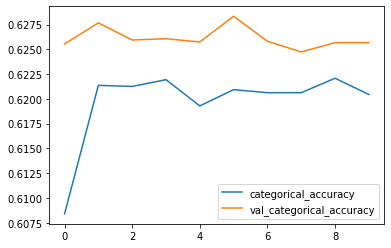

In [26]:
# Regression
# plt.plot(mlp_history.history['mean_absolute_error'], label='mean_absolute_error')
# plt.plot(mlp_history.history['val_mean_absolute_error'], label='val_mean_absolute_error')

# Classification
print(mlp_history.history.keys())
plt.plot(mlp_history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(mlp_history.history['val_categorical_accuracy'], label='val_categorical_accuracy')

plt.legend()
plt.show()

In [27]:
# Delete vars to save memory for the next tests
del X_train, X_test, X_val, y_train, y_test, y_val

# Test 3: CNN (Regression)
Only use one-hot encoded board state as features

##### Prepare Data

In [28]:
''' Load data '''
config = {
    'sample_size': 100_000
}

X, y = load_moves_data(
    csv_filename='data/lichess_db_standard_rated_2015-09___cleaned___data_max_20_moves_per_game_cpl.csv',
    sample_size=config['sample_size'],
    include_numeric=False,
    include_fens=True,
    vectorize_fens=True,
    include_target=True,
    split_X_y=True)

''' Feature scaling '''
# TODO not sure if target col should be scaled?
# scaler = skl.preprocessing.MinMaxScaler()
# y_scaled = scaler.fit_transform(y.reshape((-1, 1))).ravel()

''' Train/test/validate split '''
# X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y_scaled, test_size=0.3, random_state=0)
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5)

''' Delete unneeded vars '''
del X, y, X_test_and_val, y_test_and_val#, y_scaled

1000000it [00:02, 386645.67it/s]


Converting CSV rows to np.arrays...done.
Vectorizing FENs...done.


In [29]:
# Check shapes
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'y_val.shape: {y_val.shape}')

X_train.shape: (80000, 8, 8, 12)
X_test.shape: (10000, 8, 8, 12)
X_val.shape: (10000, 8, 8, 12)
y_train.shape: (80000,)
y_test.shape: (10000,)
y_val.shape: (10000,)


##### Fit Model

In [30]:
config.update({
    'sample_size': 100_000,
    'learning_rate': 0.01,
    'loss': 'mse',
    'optimizer': 'adam',
    'batch_size': 256,
    'epochs': 10,
})
# Optional: Log metrics to WandB
run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT_NAME,
    group='test-3',
    config=config,
    reinit=True)

cnn = ks.models.Sequential([
    ks.layers.InputLayer((8, 8, 12)),

    ks.layers.Conv2D(64, 3, padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),
    # ks.layers.MaxPool2D(),

    ks.layers.Conv2D(64, 3, padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),
    # ks.layers.MaxPool2D(),

    ks.layers.Conv2D(64, 3, padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),
    # ks.layers.MaxPool2D(),

    ks.layers.Flatten(),

    ks.layers.Dense(200, activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    # ks.layers.Dense(200),
    # ks.layers.BatchNormalization(),
    # ks.layers.LeakyReLU(),
    # ks.layers.Dropout(0.5),
    #
    # ks.layers.Dense(200),
    # ks.layers.BatchNormalization(),
    # ks.layers.LeakyReLU(),
    # ks.layers.Dropout(0.5),

    ks.layers.Dense(1, activation='linear')
])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 64)          6976      
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 64)         

In [31]:
cnn.compile(optimizer=ks.optimizers.Adam(learning_rate=config['learning_rate']),
            loss=config['loss'],
            metrics=['mse', 'mae'])

# Callback to stop when loss stops increasing
early_stopping = ks.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

# This will start the training and save each epoch output in the history list
cnn_history = cnn.fit(
    X_train, y_train,
    batch_size=config['batch_size'],
    epochs=config['epochs'],
    validation_data=(X_val, y_val),
    callbacks=[wandb.keras.WandbCallback(), early_stopping])

run.finish()

Epoch 1/10
313/313 [==============================] - 53s 165ms/step - loss: 1416529.8750 - mse: 1416529.8750 - mae: 346.9644 - val_loss: 1598567.2500 - val_mse: 1598567.2500 - val_mae: 531.1799
Epoch 2/10
313/313 [==============================] - 51s 163ms/step - loss: 1388393.0000 - mse: 1388393.0000 - mae: 367.6504 - val_loss: 1366678.8750 - val_mse: 1366678.8750 - val_mae: 368.7731
Epoch 3/10
313/313 [==============================] - 50s 161ms/step - loss: 1379883.6250 - mse: 1379883.6250 - mae: 367.4253 - val_loss: 1388954.6250 - val_mse: 1388954.6250 - val_mae: 342.1217
Epoch 4/10
313/313 [==============================] - 50s 160ms/step - loss: 1369851.2500 - mse: 1369851.2500 - mae: 366.9372 - val_loss: 1388663.3750 - val_mse: 1388663.3750 - val_mae: 325.9711
Epoch 5/10
313/313 [==============================] - 51s 164ms/step - loss: 1358173.2500 - mse: 1358173.2500 - mae: 360.9541 - val_loss: 1395262.8750 - val_mse: 1395262.8750 - val_mae: 344.5608
Epoch 6/10
313/313 [=====

epoch,▁▂▃▅▆▇█
loss,█▅▅▄▃▂▁
mae,▁███▆▇▆
mse,█▅▅▄▃▂▁
val_loss,█▁▂▂▂▁▂
val_mae,█▂▂▁▂▁▄
val_mse,█▁▂▂▂▁▂
best_epoch,1
best_val_loss,1366678.875
epoch,6
loss,1341229.125


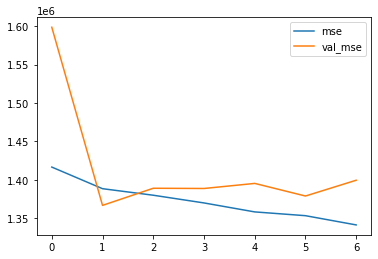

In [32]:
plt.plot(cnn_history.history['mse'], label='mse')
plt.plot(cnn_history.history['val_mse'], label='val_mse')
plt.legend()
plt.show()

In [33]:
# Delete vars to save memory for the next tests
del X_train, X_test, X_val, y_train, y_test, y_val

# Test 4: MLP Model from Research Paper

https://www.ai.rug.nl/~mwiering/GROUP/ARTICLES/ICPRAM_CHESS_DNN_2018.pdf

##### Testing the MLP Model

In [34]:
config = {
    'sample_size': 100_000,
}

X, y = load_moves_data(
    csv_filename='data/lichess_db_standard_rated_2015-09___cleaned___data_no_max_moves_per_game_cp.csv',
    sample_size=config['sample_size'],
    max_population=300_000,
    include_numeric=False,
    include_fens=True,
    vectorize_fens=True,
    include_target=True,
    split_X_y=True,
    split_numeric_fens=False,
    target_class_threshold=None,
)

# Set categories based on CP score (not CPL)
new_y = []
for cp in y:
    if cp < -150:
        new_y.append(-1)
    elif cp < 150:
        new_y.append(0)
    else:
        new_y.append(1)
y = np.array(new_y)
y = ks.utils.to_categorical(y, num_classes=3)

100000it [00:00, 414269.43it/s]


Converting CSV rows to np.arrays...done.
Vectorizing FENs...done.


In [35]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5)

del X, y, X_test_and_val, y_test_and_val

In [39]:
config.update({
    'dropout_rate': 0.2,
    'learning_rate': 0.001,
    'epochs': 100,
    'batch_size': 128,
    'optimizer': 'adam',
    'beta_1': 0.9,
    'beta_2': 0.99,
    'epsilon': 1e-8,
    'loss': 'categorical_crossentropy'
})
# Optional: Log metrics to WandB
run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT_NAME,
    group='test-4',
    config=config,
    reinit=True)

paper_model = ks.models.Sequential([
    ks.layers.InputLayer(input_shape=(8, 8, 12)),
    ks.layers.Flatten(),
    ks.layers.Dense(2048, activation='relu'),
    ks.layers.Dropout(config['dropout_rate']),
    ks.layers.Dense(500, activation='relu'),
    ks.layers.Dropout(config['dropout_rate']),
    ks.layers.Dense(50, activation='relu'),
    ks.layers.Dropout(config['dropout_rate']),
    ks.layers.Dense(3, activation='softmax')
])

paper_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_11 (Dense)            (None, 2048)              1574912   
                                                                 
 dropout_11 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 500)               1024500   
                                                                 
 dropout_12 (Dropout)        (None, 500)               0         
                                                                 
 dense_13 (Dense)            (None, 50)                25050     
                                                                 
 dropout_13 (Dropout)        (None, 50)               

In [43]:
# Callback to stop when loss stops increasing
early_stopping = ks.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=10)

paper_model.compile(
    optimizer=ks.optimizers.Adam(learning_rate=config['learning_rate'],
                                 beta_1=config['beta_1'],
                                 beta_2=config['beta_2'],
                                 epsilon=config['epsilon']),
    loss=config['loss'],
    metrics=[config['loss'], 'categorical_accuracy'])

# This will start the training and save each epoch output in the history list
paper_model_history = paper_model.fit(
    X_train, y_train,
    batch_size=config['batch_size'],
    epochs=config['epochs'],
    validation_data=(X_val, y_val),
    callbacks=[wandb.keras.WandbCallback(), early_stopping])

run.finish()

Error: You must call wandb.init() before WandbCallback()

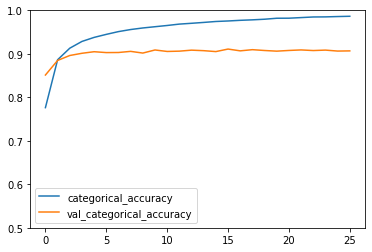

In [44]:
plt.plot(paper_model_history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(paper_model_history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.legend()
plt.ylim(0.5, 1)
plt.show()

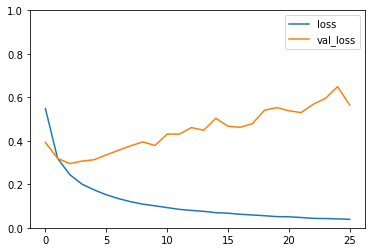

In [45]:
plt.plot(paper_model_history.history['loss'], label='loss')
plt.plot(paper_model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [46]:
# Delete vars to save memory for the next tests
del X_train, X_test, X_val, y_train, y_test, y_val

# Test 5: CNN From Paper

https://www.ai.rug.nl/~mwiering/GROUP/ARTICLES/ICPRAM_CHESS_DNN_2018.pdf

In [47]:
config = {
    'sample_size': 100_000,
}

X, y = load_moves_data(
    csv_filename='data/lichess_db_standard_rated_2015-09___cleaned___data_no_max_moves_per_game_cp.csv',
    sample_size=config['sample_size'],
    max_population=300_000,
    include_numeric=False,
    include_fens=True,
    vectorize_fens=True,
    include_target=True,
    split_X_y=True,
    split_numeric_fens=False,
    target_class_threshold=None,
)

# Set categories based on CP score (not CPL)
new_y = []
for cp in y:
    if cp < -150:
        new_y.append(-1)
    elif cp < 150:
        new_y.append(0)
    else:
        new_y.append(1)
y = np.array(new_y)
y = ks.utils.to_categorical(y, num_classes=3)

100000it [00:00, 414078.85it/s]


Converting CSV rows to np.arrays...done.
Vectorizing FENs...done.


In [48]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5)

del X, y, X_test_and_val, y_test_and_val

In [49]:
config.update({
    'learning_rate': 0.01,
    'epochs': 100,
    'optimizer': 'sgd',
    'loss': 'categorical_crossentropy',
    'batch_size': 128
})
# Optional: Log metrics to WandB
run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT_NAME,
    group='test-5',
    config=config,
    reinit=True)

paper_cnn = ks.models.Sequential([
    ks.layers.InputLayer(input_shape=(8, 8, 12)),
    ks.layers.Conv2D(20, (5, 5), padding='same', activation='relu'),
    ks.layers.Dropout(0.3),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(50, (3, 3), padding='same', activation='relu'),
    ks.layers.Dropout(0.3),
    ks.layers.BatchNormalization(),

    ks.layers.Flatten(),
    ks.layers.Dense(500, activation='relu'),

    ks.layers.Dense(3, activation='softmax')
])

paper_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 8, 8, 20)          6020      
                                                                 
 dropout_14 (Dropout)        (None, 8, 8, 20)          0         
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 20)         80        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 50)          9050      
                                                                 
 dropout_15 (Dropout)        (None, 8, 8, 50)          0         
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 50)         200       
 hNormalization)                                      

In [ ]:
# Callback to stop training when validation loss stops decreasing
early_stopping = ks.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

paper_cnn.compile(
    optimizer=ks.optimizers.SGD(learning_rate=config['learning_rate']),
    loss=config['loss'],
    metrics=[config['loss'], 'categorical_accuracy'])

# This will start the training and save each epoch output in the history list
paper_cnn_history = paper_cnn.fit(
    X_train, y_train,
    batch_size=config['batch_size'],
    epochs=config['epochs'],
    validation_data=(X_val, y_val),
    callbacks=[wandb.keras.WandbCallback(), early_stopping])

run.finish()

Epoch 1/100
625/625 [==============================] - 27s 41ms/step - loss: 0.8161 - categorical_crossentropy: 0.8161 - categorical_accuracy: 0.6355 - val_loss: 0.6858 - val_categorical_crossentropy: 0.6858 - val_categorical_accuracy: 0.7053
Epoch 2/100
625/625 [==============================] - 26s 41ms/step - loss: 0.7182 - categorical_crossentropy: 0.7182 - categorical_accuracy: 0.6859 - val_loss: 0.6365 - val_categorical_crossentropy: 0.6365 - val_categorical_accuracy: 0.7343
Epoch 3/100
625/625 [==============================] - 26s 41ms/step - loss: 0.6765 - categorical_crossentropy: 0.6765 - categorical_accuracy: 0.7083 - val_loss: 0.5983 - val_categorical_crossentropy: 0.5983 - val_categorical_accuracy: 0.7496
Epoch 4/100
625/625 [==============================] - 26s 42ms/step - loss: 0.6447 - categorical_crossentropy: 0.6447 - categorical_accuracy: 0.7266 - val_loss: 0.5685 - val_categorical_crossentropy: 0.5685 - val_categorical_accuracy: 0.7640
Epoch 5/100
625/625 [=======

In [ ]:
plt.plot(paper_cnn_history.history['categorical_crossentropy'], label='categorical_crossentropy')
plt.plot(paper_cnn_history.history['val_categorical_crossentropy'], label='val_categorical_crossentropy')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [ ]:
plt.plot(paper_cnn_history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(paper_cnn_history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.legend()
plt.ylim(0.5, 1)
plt.show()